In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
)

pd.set_option("display.max_columns", 50)

In [4]:
train_path = "Train_data.csv"

data = pd.read_csv(train_path)

print("Data shape:", data.shape)
print("\nColumns:")
print(data.columns.tolist())

print("\nHead of data:")
print(data.head())

Data shape: (25192, 42)

Columns:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']

Head of data:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0 

In [5]:
if "class" not in data.columns:
    raise ValueError("Expected a 'class' column in Train_data.csv.")

y = (data["class"] != "normal").astype(int)   # 0 = normal, 1 = attack

print("Label counts (0=normal, 1=attack):")
print(y.value_counts())


Label counts (0=normal, 1=attack):
class
0    13449
1    11743
Name: count, dtype: int64


In [6]:
selected_features = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "logged_in",
    "count",
    "srv_count",
]

# just in case, keep only features that actually exist
selected_features = [c for c in selected_features if c in data.columns]

print("Using features:", selected_features)

X = data[selected_features].copy()
print("X shape:", X.shape)

Using features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count']
X shape: (25192, 9)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:",  X_test.shape[0])

Train size: 17634
Test size: 7558


In [8]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# one-hot encode categoricals
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# make sure test has the same dummy columns as train
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoded X_train shape:", X_train_enc.shape)
print("Encoded X_test shape:",  X_test_enc.shape)

Categorical columns: ['protocol_type', 'service', 'flag']
Numeric columns: ['duration', 'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count']
Encoded X_train shape: (17634, 83)
Encoded X_test shape: (7558, 83)


In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_enc, y_train)

y_pred = knn.predict(X_test_enc)

acc = accuracy_score(y_test, y_pred)
print("Base KNN accuracy:", acc)
print("\nClassification report (base KNN):")
print(classification_report(y_test, y_pred))

Base KNN accuracy: 0.9866366763694099

Classification report (base KNN):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4035
           1       0.99      0.98      0.99      3523

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558



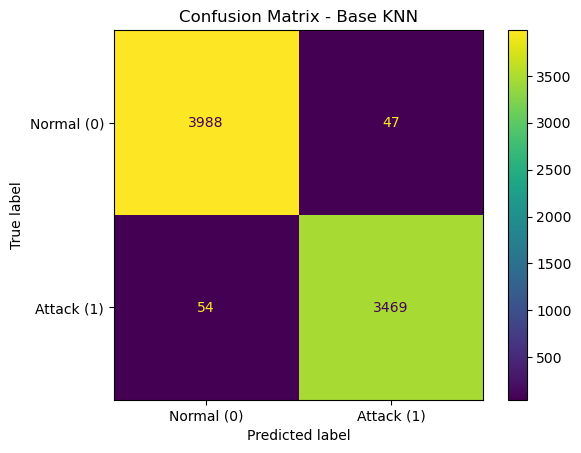

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal (0)", "Attack (1)"]
)
disp.plot(values_format="d")
plt.title("Confusion Matrix - Base KNN")
plt.show()

In [11]:
param_grid = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan"],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train_enc, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV accuracy: 0.9909833276624701


Test accuracy (best KNN): 0.9928552527123577

Classification report (best KNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4035
           1       1.00      0.99      0.99      3523

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558



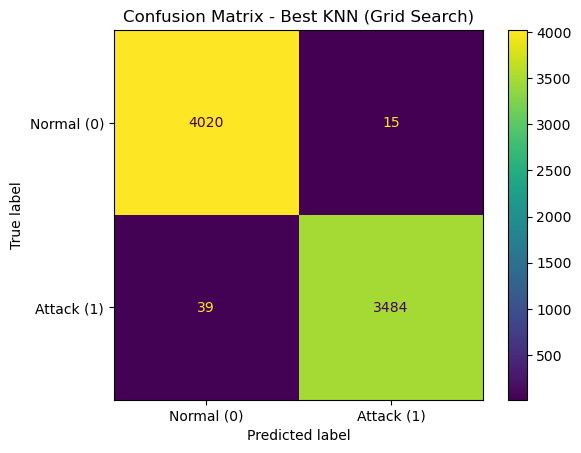

In [12]:
best_knn = grid.best_estimator_

y_pred_best = best_knn.predict(X_test_enc)

acc_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy (best KNN):", acc_best)
print("\nClassification report (best KNN):")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=[0, 1])
disp_best = ConfusionMatrixDisplay(
    confusion_matrix=cm_best,
    display_labels=["Normal (0)", "Attack (1)"]
)
disp_best.plot(values_format="d")
plt.title("Confusion Matrix - Best KNN (Grid Search)")
plt.show()